In [ ]:
!pip install torch
!apt-get install graphviz -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


load datasets, scale data to be in [0,1]

In [18]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def loadDatasets():
  with open(r"/home/data/MackeyGlass/train.pickle", "rb") as file:
      data = pickle.load(file)
      train_data = data['data']
  with open(r"/home/data/MackeyGlass/test.pickle", "rb") as file:
      data = pickle.load(file)
      test_data = data['data']
  with open(r"/home/data/MackeyGlass/val.pickle", "rb") as file:
      data = pickle.load(file)
      validation_data = data['data']

  return train_data, test_data, validation_data

def basicStatistics(data):
  # Basic statistics
  mean_values = np.mean(data, axis=1)  # Compute mean along each column (axis=0)
  std_dev_values = np.std(data, axis=1)  # Compute standard deviation along each column
  min_values = np.min(data, axis=1)  # Compute minimum along each column
  max_values = np.max(data, axis=1)  # Compute maximum along each column
  # Display
  # print("Mean values: {}, size {}".format(mean_values, len(mean_values)))
  # print("Standard deviation values:", std_dev_values)
  # print("Minimum values:", min_values)
  # print("Maximum values:", max_values)
  print("Mean values: {}".format(np.mean(mean_values)))
  # print("Standard deviation values:", np.std(std_dev_values))
  totalMin = np.min(min_values)
  totalMax = np.max(max_values)
  print("Minimum values:", np.min(min_values))
  print("Maximum values:", np.max(max_values))
  return totalMin, totalMax

def normalize(data, minVal, maxVal):
  scaledData = (data- minVal)/(maxVal-minVal)
  return scaledData

def denormalize(data, minVal, maxVal):
  dnData = minVal +data*(maxVal-minVal)
  return dnData

train_data, test_data, validation_data = loadDatasets()
#print(train_data.shape, test_data.shape, validation_data.shape) #The shape of the data is (100, 1000, 1).
#plt.plot(train_data[31, :])
trainMin, trainMax = basicStatistics(train_data)
# basicStatistics(test_data)
# basicStatistics(validation_data)
train_data = normalize(train_data, trainMin, trainMax)
test_data = normalize(test_data, trainMin, trainMax)
validation_data = normalize(validation_data, trainMin, trainMax)


Mean values: 0.9303278353202756
Minimum values: 0.20320343676859462
Maximum values: 1.545840411582791


Implementation of the different networks used: CNN, LSTM, transformer for n hidden layers.

In [2]:
class TimeSeriesCNN1(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1):
        super(TimeSeriesCNN1, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = x.mean(dim=2)
        #x = x.view(x.size(0), -1)  # Flatten the output for fully connected layer
        x = self.fc(x)
        return x

class TimeSeriesCNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim=1, kernel_size=3):
        super(TimeSeriesCNN, self).__init__()

        # Create a list of convolutional layers dynamically
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(in_channels=input_dim if i == 0 else hidden_dims[i - 1],
                      out_channels=hidden_dims[i],
                      kernel_size=kernel_size,
                      padding=kernel_size // 2)  # Maintain the same size
            for i in range(len(hidden_dims))
        ])

        self.relu = nn.ReLU()
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)  # Global average pooling over the time dimension
        self.fc = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, x):
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
            x = self.relu(x)

        x = self.global_avg_pooling(x)
        x = x.view(x.size(0), -1)  # Flatten the output for fully connected layer
        x = self.fc(x)
        return x

class TimeSeriesRNN1(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super(TimeSeriesRNN1, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.relu(h_n[-1, :, :])  # Take the hidden state from the last time step
        x = self.fc(x)
        return x

class TimeSeriesRNN(nn.Module):
    def __init__(self, input_dim=1, hidden_dims=[64], output_dim=1):
        super(TimeSeriesRNN, self).__init__()

        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)):
            if i == 0:
                self.hidden_layers.append(nn.LSTM(input_size=input_dim, hidden_size=hidden_dims[i], batch_first=True))
            else:
                self.hidden_layers.append(nn.LSTM(input_size=hidden_dims[i-1], hidden_size=hidden_dims[i], batch_first=True))

        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, x):
        for layer in self.hidden_layers:
            x, _ = layer(x)

        x = self.relu(x[:, -1, :])  # Take the hidden state from the last time step of the last layer
        x = self.fc(x)
        return x


class TransformerLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, nhead=1):
        super(TransformerLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(hidden_dim, nhead)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        print("In loop shape01 ", x.shape)
        attn_output, _ = self.self_attn(x, x, x)
        print("In loop shape02 ", attn_output.shape)
        x = x + attn_output
        print("In loop shape03 ", x.shape)
        x = self.layer_norm1(x)
        print("In loop shape04 ", x.shape)
        ff_output = self.feed_forward(x)
        x = x + ff_output
        x = self.layer_norm2(x)

        return x

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1, num_layers=1, nhead=1):
        super(TimeSeriesTransformer, self).__init__()

        # Transformer layers
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(input_dim, hidden_dim, nhead)
            for _ in range(num_layers)
        ])

        # Linear layer for prediction
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Transformer layers
        print("Initial shape ", x.shape)
        for layer in self.transformer_layers:
            x = layer(x)
            print("In loop shape ", x.shape)

        # Linear layer for prediction
        x = self.fc(x.squeeze(dim=0))  # Squeeze the time dimension
        return x


Auxiliary functions for exporting results.

In [3]:
def log(file, line, printScreen=False, changeLine=True):
  f = open(file, "a+")
  if changeLine:
      f.write(line + "\n")
  else:
      f.write(line)
  f.close()
  if printScreen:
    print(line)

def writeToFile(fname, *args):
  f = open(fname, "w")
  for iprop in args:
      f.write(iprop)
  f.close()

def writeList(fname, field):
  f = open(fname, 'w')
  for fi in field:
    s1 = str(fi) +'\n'
    f.write(s1)
  f.close()

Create dataset loaders using a simplistic approach instead of inheriting from Dataset class for proof of concept.

In [4]:
def createDataLoader(data, sequenceSize, batchSize):
  dataTensor = torch.Tensor(data)
  inputData = dataTensor[:, :sequenceSize, :]
  targetData = dataTensor[:, sequenceSize:sequenceSize+1, :]
  dataset = TensorDataset(inputData, targetData)
  datasetLoader = DataLoader(dataset, batch_size=batchSize, shuffle=True)
  return datasetLoader

Train and validate the model.

In [ ]:
batch_size = 32  # Adjust as needed
sequence_length = 801 # the points of the trajectory that will be used for training
bestLoss = 100.0

# Create DataLoader for training, validation
train_loader = createDataLoader(train_data, sequence_length, batch_size)
valid_loader = createDataLoader(validation_data, sequence_length, batch_size)

# Instantiate the model, loss function, and optimizer
model = TimeSeriesCNN(input_dim= sequence_length, hidden_dims = [512, 256, 128, 64])
# model = TimeSeriesRNN(input_dim= sequence_length)#, hidden_dims = [512, 256, 128, 64])
# model = TimeSeriesTransformer(input_dim= sequence_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100  # Adjust as needed
trainLoss =[]
validLoss = []
for epoch in range(num_epochs):

    #training
    trainAccLoss = 0.0
    for input, target in train_loader:
        target = target.squeeze(dim=2)
        #print("Inputs size: {}".format(input.shape))
        output = model(input)

        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trainAccLoss += loss.item()
    trainAccLoss /= len(train_loader)
    trainLoss.append(trainAccLoss)

    #validation
    model.eval()
    validAccLoss = 0.0
    for input, target in valid_loader:
        target = target.squeeze(dim=2)
        #print("Inputs size: {}".format(input.shape))
        output = model(input)

        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        validAccLoss += loss.item()
    validAccLoss /= len(valid_loader)
    validLoss.append(validAccLoss)
    if validAccLoss<bestLoss:
      torch.save(model.state_dict(), "/home/data/MackeyGlass/bestModel")
      print("Validation loss reduced, saving model ...")
      bestLoss = validAccLoss

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {trainAccLoss}, Validation Loss: {validAccLoss}")
writeList( "/home/data/MackeyGlass/trainLoss.dat", trainLoss)
writeList( "/home/data/MackeyGlass/validLoss.dat", validLoss)

Validation loss reduced, saving model ...
Epoch 1/100, Train Loss: 0.19152509793639183, Validation Loss: 0.05171716306358576
Validation loss reduced, saving model ...
Epoch 2/100, Train Loss: 0.03755259793251753, Validation Loss: 0.028973629232496023
Validation loss reduced, saving model ...
Epoch 3/100, Train Loss: 0.021864339243620634, Validation Loss: 0.019668451976031065
Epoch 4/100, Train Loss: 0.015667993808165193, Validation Loss: 0.021975926123559475
Validation loss reduced, saving model ...
Epoch 5/100, Train Loss: 0.020282501820474863, Validation Loss: 0.01653113798238337
Validation loss reduced, saving model ...
Epoch 6/100, Train Loss: 0.015176794957369566, Validation Loss: 0.016059284331277013
Validation loss reduced, saving model ...
Epoch 7/100, Train Loss: 0.011565615888684988, Validation Loss: 0.013279949547722936
Epoch 8/100, Train Loss: 0.012095397338271141, Validation Loss: 0.014266988495364785
Validation loss reduced, saving model ...
Epoch 9/100, Train Loss: 0.013

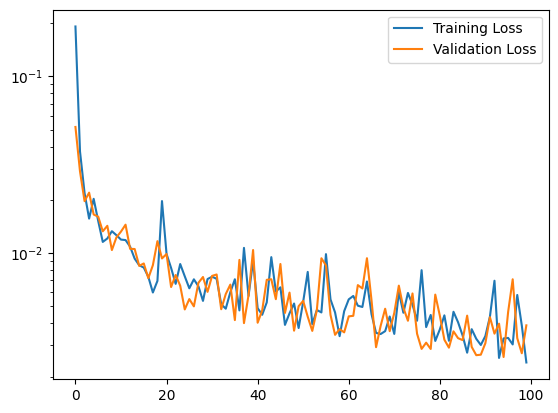

In [ ]:
plt.plot(trainLoss, label='Training Loss')
plt.plot(validLoss, label='Validation Loss')
plt.yscale('log')
plt.legend()

Load model and estimate the error in the test dataset.

In [21]:
batch_size = 1
sequence_length = 801

# Create DataLoader for training, validation
test_loader = createDataLoader(test_data, sequence_length, batch_size)

# Initialize model, call constructor
# model = TimeSeriesCNN(input_dim= sequence_length, hidden_dims = [512, 256, 128, 64])
model = TimeSeriesRNN(input_dim= sequence_length)
model_state_dict = torch.load("/home/data/MackeyGlass/bestModel")
# Load the model weights
model.load_state_dict(model_state_dict)

model.eval()
criterion = nn.MSELoss()

testAccLoss = 0.0
error = []
with torch.no_grad():
    for input, target in test_loader:
      target = target.squeeze(dim=2)
      output = model(input)
      loss = criterion(output, target)
      testAccLoss += loss.item()
      targetDn = denormalize(target.item(), trainMin, trainMax)
      outputDn = denormalize(output.item(), trainMin, trainMax)
      relError = abs(targetDn-outputDn)/abs(targetDn)
      error.append(relError)
testAccLoss /= len(test_loader)

nperror = np.array(error)
meanError = np.mean(nperror)

print(f"Test Loss: {testAccLoss}, mean relative error: {meanError*100} %")

Test Loss: 0.0022781649651685497, mean relative error: 6.130227915998714 %
